# Análisis de Sentimientos Multifuente con TF-IDF y Naive Bayes

- En este trabajo voy a construir un clasificador de sentimientos a partir del All-in-One Sentiment Dataset. Primero cargaré el archivo local y detectaré las columnas de texto y etiqueta; luego dividiré los datos en entrenamiento y prueba. Transformaré los textos con TF-IDF y entrenaré un Naive Bayes Multinomial para distinguir opiniones positivas/negativas (y, si aplica, neutras). Finalmente evaluaré el modelo (accuracy, reporte y matriz de confusión) y lo usaré para predecir frases nuevas. Finalidad: obtener una línea base fiable y reproducible que me sirva para comparar mejoras futuras (mejores features, otros algoritmos o ajuste de hiperparámetros) y para aplicar el modelo a nuevos textos del mismo dominio.

# 1️⃣ Librerías

In [3]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 120)
print("Librerías cargadas ✅")


Librerías cargadas ✅


# 2️⃣ Carga del dataset 

In [4]:
# 👉 Cambia a tu archivo subido
RUTA_ARCHIVO = "balanced_sentiment_dataset.csv"   # o .xlsx

# Carga flexible
ext = os.path.splitext(RUTA_ARCHIVO)[1].lower()
if ext == ".csv":
    df = pd.read_csv(RUTA_ARCHIVO, encoding="utf-8", engine="python")
elif ext in [".xls", ".xlsx"]:
    df = pd.read_excel(RUTA_ARCHIVO)
else:
    raise ValueError("Formato no soportado. Usa .csv, .xls o .xlsx")

print(df.shape)
display(df.head())
print(df.columns.tolist())


(80000, 2)


,sentiment,text
0,1,"And here is the rap song ""African Warrior Queens"", for which ChatGPT wrote the lyrics 🤎 Yes, amateur but beautiful :..."
1,1,"We asked chatGPT ,\n\nHow to become a successful trader?\n\nHere is what it thinks,\n\n#ChatGPT https://t.co/UKfbOqyurW"
2,0,When I finally manage to convince myself to peel out from under the sheets each morning the second thing I'm interes...
3,0,"Although a healthier alternative to your typical vanilla extract, I purchased this product to add some vanilla flavo..."
4,1,"In my latest test, I asked #ChatGPT to write me a welcome letter for our attendees for banking school. #bankingschoo..."


['sentiment', 'text']


# 3️⃣ Selección de columnas

In [5]:
# 🔎 Detección heurística (ajústalo si no acierta)
text_candidates  = [c for c in df.columns if c.lower() in ["text","review","tweet","content","comment","sentence","message","texto","reseña","resena"] or "text" in c.lower()]
label_candidates = [c for c in df.columns if c.lower() in ["label","sentiment","polarity","target","class","etiqueta"] or "sentiment" in c.lower()]

TEXT_COL  = text_candidates[0]  if text_candidates else None
LABEL_COL = label_candidates[0] if label_candidates else None

# 👉 Si conoces los nombres exactos, descomenta y fija:
# TEXT_COL  = "texto"
# LABEL_COL = "sentiment"

assert TEXT_COL is not None and LABEL_COL is not None, "Ajusta TEXT_COL/LABEL_COL a los nombres reales."
df = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL:"texto", LABEL_COL:"etiqueta"}).dropna()
df = df[df["texto"].astype(str).str.strip()!=""].copy()

print(df.shape)
display(df.head())
print(df["etiqueta"].value_counts())


(80000, 2)


,texto,etiqueta
0,"And here is the rap song ""African Warrior Queens"", for which ChatGPT wrote the lyrics 🤎 Yes, amateur but beautiful :...",1
1,"We asked chatGPT ,\n\nHow to become a successful trader?\n\nHere is what it thinks,\n\n#ChatGPT https://t.co/UKfbOqyurW",1
2,When I finally manage to convince myself to peel out from under the sheets each morning the second thing I'm interes...,0
3,"Although a healthier alternative to your typical vanilla extract, I purchased this product to add some vanilla flavo...",0
4,"In my latest test, I asked #ChatGPT to write me a welcome letter for our attendees for banking school. #bankingschoo...",1


etiqueta
1    40000
0    40000
Name: count, dtype: int64


# 4️⃣ Train/Test split

In [6]:
X = df["texto"].astype(str)
y = df["etiqueta"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (64000,)  Test: (16000,)


# 5️⃣ Pipeline

In [7]:
# Idioma para stopwords: "es" (español) o "en" (inglés)
IDIOMA = "es"  # cambia a "en" si tu dataset está en inglés

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        ngram_range=(1,2),      # unigrams + bigrams
        min_df=2,               # ignora términos muy raros
        max_df=0.95,            # ignora términos demasiado comunes
        sublinear_tf=True,
        stop_words=("spanish" if IDIOMA=="es" else "english")
    )),
    ("nb", MultinomialNB(alpha=1.0))
])


# 6️⃣ Entrenamiento

In [15]:
pipe.fit(X_train, y_train)
print("Modelo entrenado ✅")


Modelo entrenado ✅


# 7️⃣ Evaluación

Accuracy: 0.8261

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      8000
           1       0.81      0.85      0.83      8000

    accuracy                           0.83     16000
   macro avg       0.83      0.83      0.83     16000
weighted avg       0.83      0.83      0.83     16000



<Figure size 500x400 with 0 Axes>

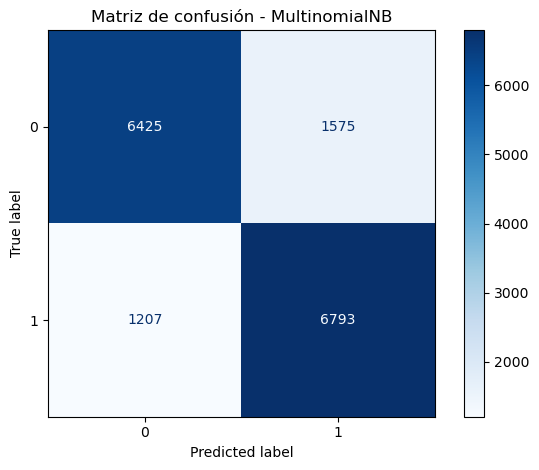

In [16]:
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
labels_orden = sorted(pd.unique(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels_orden)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_orden)

plt.figure(figsize=(5,4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - MultinomialNB")
plt.tight_layout()
plt.show()


# 8️⃣ Predicción en nuevos textos

In [17]:
def predecir(textos):
    """
    textos: list[str] o pd.Series
    return: DataFrame con texto y predicción
    """
    textos = pd.Series(textos, name="texto").astype(str)
    preds = pipe.predict(textos)
    probs = None
    try:
        probs = pipe.predict_proba(textos).max(axis=1)
    except Exception:
        pass
    out = pd.DataFrame({"texto": textos, "prediccion": preds})
    if probs is not None:
        out["confianza_max"] = probs
    return out

# Ejemplo:
ejemplo = ["el servicio fue excelente", "la comida llegó fría y tarde"]
predecir(ejemplo)


,texto,prediccion,confianza_max
0,el servicio fue excelente,0,0.5
1,la comida llegó fría y tarde,0,0.5


# 9️⃣ Guardar el modelo y el vectorizador

In [18]:
import joblib
joblib.dump(pipe, "modelo_tfidf_nb.joblib")
print("Modelo guardado en modelo_tfidf_nb.joblib")


Modelo guardado en modelo_tfidf_nb.joblib
